## Creating a graph using bigrams vs using NER (spacy)
----------

In [119]:
from pandas import pandas as pd
from nltk import word_tokenize
from nltk import ngrams
from nltk import *
from siuba import count

%store -r game_text_cleaned
%store -r swords_text_cleaned

%store -r game_df_cleaned
%store -r swords_df_cleaned


In [120]:
def find_characters(text : str, book_name : str):
    text_str = ""
    for _list in text:
        for string in _list:
            text_str += string + ' '

    verbs = ['VB', 'VBD', 'VBZ', 'VBG', 'VBP', 'VBN']
    not_good = ['NNS', 'PDT', 'FW', 'EX', 'PRP', 'RB', 'RBR', 'RBS', 'UH', 'TO', 'CC', 'CD', 'WDT', 'WP', 'WRB']
    good = ['NNP']
    not_good += verbs
    token = word_tokenize(text_str)
    verb_list = []
    not_good_list = []
    good_list = []

    for tag in pos_tag(token):
        if tag[1] in verbs:
            verb_list.append(tag[0])
        elif tag[1] in not_good:
            not_good_list.append(tag[0])
        elif tag[1] in good:
            good_list.append(tag[0])



    df_bigrams_ = ngrams(token, 2)
    df_bigrams = [ ' '.join(grams) for grams in df_bigrams_]
    df = pd.DataFrame({
        "book" : book_name,
        "bigrams": df_bigrams
    })
    df[['word1', 'word2']] = df['bigrams'].str.split(expand=True)
    df = df[~df.word1.isin(verb_list)]
    df = df[df.word2.isin(verb_list)]
    df = df[df.word1.str.istitle()]
    df = df[~df.word1.isin(not_good_list)]
    df = df[df.word1.isin(good_list)]

    var = count(df, 'word1', sort=True)
    character_list = []
    for character1 in var['word1']:
        tmp_chars = []
        index_c1 = -1
        index_c1 = text_str.find(character1)
        if index_c1 >= 0:
            for character2 in var['word1']:
                if character1 != character2:
                    idx_c2 = text_str.find(character2, index_c1, len(text_str) - 1)
                    if idx_c2 > index_c1:
                        tmp_chars.append((character1, character2, idx_c2 - index_c1))
            if tmp_chars:
                tmp_chars.sort(reverse=False, key = lambda x : x[2])
                character_list += tmp_chars[:5]


    return character_list


def create_bigram(text, book_name : str):
    character_list = find_characters(text, book_name)
    # print(character_list)
    df = pd.DataFrame(character_list, columns=["Character1", "Character2", "Distance"])
    return df


game_df_bi = create_bigram(game_text_cleaned[:10000], "A Game of Thrones")
game_df_bi



,Character1,Character2,Distance
0,Ned,First,38
1,Ned,Bran,311
2,Ned,Brandon,311
3,Ned,Builder,319
4,Ned,Up,490
...,...,...,...
2515,Young,Dragon,6
2516,Young,Boy,43
2517,Young,Someone,76
2518,Young,Targaryen,104


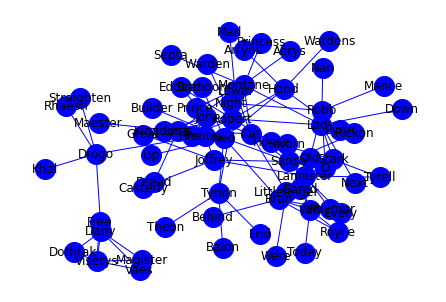

<Figure size 432x288 with 0 Axes>

In [126]:
import networkx as nx
from siuba import count

# Create our Graph object
game_df_bi_graph = count(game_df_bi.head(100), 'Character1','Character2', 'Distance', sort=True)
game_df_bi_graph.drop(columns=['Distance'])
G = nx.from_pandas_edgelist(df=game_df_bi_graph, source='Character1', target='Character2', edge_attr='n')

import matplotlib.pyplot as plt

# Time to draw it
nx.draw(G, pos=nx.spring_layout(G, k=1.45, iterations=220), node_size=400, font_size=12, node_color='b', edge_color='b', with_labels=True)

plt.show()
plt.savefig('sth.pdf', dpi=300, bbox_inches='tight') # can also save it to file